In [1]:
import torch
import numpy as np
import sklearn as skl
from torch.autograd import Variable
from torch.nn import Parameter

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
class NormalDist(torch.nn.Module):
    
    def __init__(self,  mu=np.zeros(1), sigma=np.ones(1), param=True):
        super(NormalDist, self).__init__()
        if param:
            self.mu = Parameter(torch.from_numpy(mu), requires_grad=True)
            self.log_sigma = Parameter(torch.from_numpy(np.log(sigma)), requires_grad=True)
        else:
            self.mu = Variable(torch.from_numpy(mu), requires_grad=True)
            self.log_sigma = Variable(torch.from_numpy(np.log(sigma)), requires_grad=True)
        
    def log_pdf(self, x, mu=None, sigma=None):
        if mu is None:
            mu = self.mu
        if sigma is None:
            sigma = torch.exp(self.log_sigma)
        normalizer = -0.5*torch.log(2*np.pi*sigma**2)
        exponent = -0.5 * ((x-mu)**2)/(sigma**2)
        return normalizer + exponent
    
    def pdf(self, x, mu=None, sigma=None):
        return torch.exp(self.log_pdf(x, mu, sigma))
    
    def sample(self, shape):
        z = np.random.normal(size=shape)
        z_t = Variable(torch.from_numpy(z))
        return self.mu + z_t * torch.exp(self.log_sigma)
        
        
        
class LogNormalDist(torch.nn.Module):
    def __init__(self, mu=np.zeros(1), s=np.ones(1), param=True):
        super(LogNormalDist, self).__init__()
        if param:
            self.mu = Parameter(torch.from_numpy(mu))
            self.log_s = Parameter(torch.from_numpy(np.log(s)))
        else:
            self.mu = Variable(torch.from_numpy(mu), requires_grad=True)
            self.log_s = Variable(torch.from_numpy(np.log(s)), requires_grad=True)
        
    def log_pdf(self, x):
        normalizer = -0.5*torch.log((x**2)*torch.exp(2*self.log_s)*2*np.pi)
        exponent = - ((torch.log(x)-self.mu)**2)/(2*torch.exp(2*self.log_s))
        return normalizer + exponent
    
    def pdf(self, x):
        return torch.exp(self.log_pdf(x))
    
    def sample(self, n):
        z = np.random.normal(size=(len(self.mu), n))
        z_t = Variable(torch.from_numpy(z))
        return torch.exp(self.mu + z_t * torch.exp(self.log_s))
        

In [122]:
m = NormalDist(np.zeros(1), np.ones(1))
lm = LogNormalDist(np.zeros((1)), np.ones((1)))

 $P(\sigma) \sim \mathcal{LogN}(\sigma \mid 0, 1)$
 
 $P(y \mid \sigma) \sim \mathcal{N}(y \mid \sigma,1)$
 
 This is a non-conjugate model. We want to find $P(\sigma \mid y)$, which we assume is intractable.
 


## Procedure

* Generate data, a batch of `y` points, in this case by ancestral sampling.

* Decide on approximation class and instantiate q(\sigma).

* Sample `n_samples` from q using reparametrization trick.

* Compute $E_q[log \ P(y \mid \sigma)]$ approximately by $\frac{1}{N} \sum_{i=1}^{N}log \ P(y \mid \sigma)$.

* Compute $E_q[log \ q(\sigma) - log \ P(\sigma)]$ by the same method.

* Sum to make the ELBO, and take gradient step and repeat!

In [230]:
N = 1000

X = np.random.lognormal(size=(N, 1))
T = np.random.normal(loc=X)

In [231]:
q = LogNormalDist(param=True)
prior = LogNormalDist(param=False)
p = NormalDist(mu=np.zeros((1,1)))
opt = torch.optim.Adam(params=q.parameters(), lr=0.4)
mask = np.arange(s.shape[0])
batch_size=1000
n_samples=100
for t in range(5000):
    
    y = Variable(torch.from_numpy(X))
    target = Variable(torch.from_numpy(T))
    s = q.sample(n_samples)
    ll = torch.mean(torch.sum(p.log_pdf(target, mu=s), dim=0))
    kld = torch.mean( q.log_pdf(s)-prior.log_pdf(s))
    
    loss = -(ll - kld)
    if t%1000 == 0:
        print(loss.data.numpy())
    opt.zero_grad()
    loss.backward()
    
    opt.step()

[ 10183.16398385]
[ 3907.92149339]
[ 3907.79901415]
[ 3907.77649053]
[ 3907.79023736]


In [232]:
q.mu

Parameter containing:
 0.4266
[torch.DoubleTensor of size 1]

In [233]:
torch.exp(q.log_s)

Variable containing:
1.00000e-02 *
  2.0311
[torch.DoubleTensor of size 1]

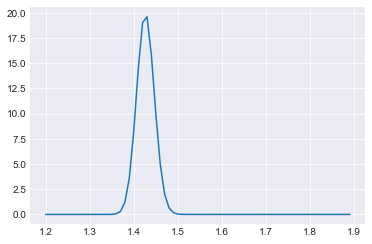

In [238]:
from scipy.stats import lognorm, norm

l = lognorm(loc=0.4266, s=0.02)
a = np.arange(1.2, 1.9, 0.01)
plt.plot(a, l.pdf(a))

## Validation

In [235]:
import pymc3 as pm
import numpy as np

%matplotlib inline
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as st

plt.style.use('seaborn-darkgrid')

In [236]:
basic_model = pm.Model()
a = np.random.normal(loc=np.random.lognormal(size=1000))
with basic_model:

    prior = pm.Lognormal('p',mu=0, tau=1)
    likelihood = pm.Normal('like',mu=prior, tau=1.0, observed=T)
    

    trace = pm.sample(10000, pm.NUTS())

100%|██████████| 10000/10000 [00:04<00:00, 2149.99it/s]


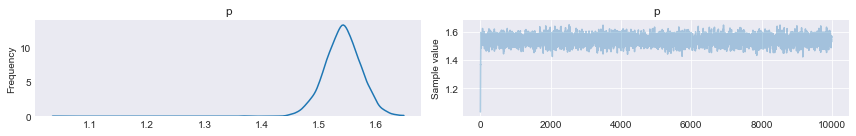

In [237]:
pm.traceplot(trace);